# Tuning free ridge regression with conformal prediction

In [149]:
library(glmnet)
library(MASS)
library(mvtnorm)
source("ridge_funs.R")
name=paste("linear_fm_t3",sep="")


df <- 3  #degrees of freedom
l <- 60    #number of dimensions 
l.lambda <- 100
lambda_seq <- seq(0,200,l=l.lambda)
dim <- round(seq(5,300,l=l))
alpha <- 0.1
n <- 200   #number of training samples
n0 <- 100  #number of prediction points
nrep <- 100 #number of independent trials
rho <- 0.5

cov.efcp <- len.efcp <- matrix(0,nrep,l)
cov.vfcp <- len.vfcp <- matrix(0,nrep,l)
cov.naive <- len.naive <- matrix(0,nrep,l)
cov.param <- len.param <- matrix(0,nrep,l)
cov.star <- len.star <- matrix(0,nrep,l)
cov.cv10 <- len.cv10 <- matrix(0,nrep,l)
cov.cv5 <- len.cv5 <- matrix(0,nrep,l)
cov.cvloo <- len.cvloo <- matrix(0,nrep,l)


out.efcp.up <- out.efcp.lo <- matrix(0,n0,l)
out.vfcp.up <- out.vfcp.lo <- matrix(0,n0,l)
out.naive.up <- out.naive.lo <- matrix(0,n0,l)
out.param.up <- out.param.lo <- matrix(0,n0,l)
out.star.up <- out.star.lo <- matrix(0,n0,l)
out.cv10.up <- out.cv10.lo <- matrix(0,n0,l)
out.cv5.up <- out.cv5.lo <- matrix(0,n0,l)
out.cvloo.up <- out.cvloo.lo <- matrix(0,n0,l)


for(i in 1:nrep){
  if(i%%10 == 0){
    print(i)
  }
  for (r in 1:l){
    d <- dim[r]
    set.seed(i)
    
    Sigma <- matrix(rho,d,d)
    diag(Sigma) <- rep(1,d)
    X <- rmvt(n,Sigma,df)	#multivariate t distribution
    beta <- rep(1:5,d/5)
    eps <- rt(n,df)*(1+sqrt(X[,1]^2+X[,2]^2))
    Y <- X%*%beta+eps
    
    
    X0 <- rmvt(n0,Sigma,df)
    eps0 <- rt(n0,df)*(1+sqrt(X0[,1]^2+X0[,2]^2))
    Y0 <- X0%*%beta+eps0
    
    
    out.param <- ginverse.fun(X,Y,X0,alpha=alpha)
    out.param.lo[,r] <- out.param$lo
    out.param.up[,r] <- out.param$up    
    cov.param[i,r] <- mean(out.param.lo[,r] <= Y0 & Y0 <= out.param.up[,r]) 
    len.param[i,r] <- mean(out.param.up[,r]-out.param.lo[,r]) 
    
    
    out.efcp <- efcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.efcp.up[,r] <- out.efcp$up
    out.efcp.lo[,r] <- out.efcp$lo    
    cov.efcp[i,r] <- mean(out.efcp.lo[,r] <= Y0 & Y0 <= out.efcp.up[,r]) 
    len.efcp[i,r] <- mean(out.efcp.up[,r]-out.efcp.lo[,r]) 
    
    
    out.vfcp <- vfcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.vfcp.up[,r] <- out.vfcp$up
    out.vfcp.lo[,r] <- out.vfcp$lo    
    cov.vfcp[i,r] <- mean(out.vfcp.lo[,r] <= Y0 & Y0 <= out.vfcp.up[,r]) 
    len.vfcp[i,r] <- mean(out.vfcp.up[,r]-out.vfcp.lo[,r]) 
    
    out.naive <- naive.fun(X,Y,X0,alpha=alpha)
    out.naive.up[,r] <- out.naive$up
    out.naive.lo[,r] <- out.naive$lo    
    cov.naive[i,r] <- mean(out.naive.lo[,r] <= Y0 & Y0 <= out.naive.up[,r]) 
    len.naive[i,r] <- mean(out.naive.up[,r]-out.naive.lo[,r]) 
    
    
    out.star <- star.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.star.up[,r] <- out.star$up
    out.star.lo[,r] <- out.star$lo   
    cov.star[i,r] <- mean(out.star.lo[,r] <= Y0 & Y0 <= out.star.up[,r]) 
    len.star[i,r] <- mean(out.star.up[,r] - out.star.lo[,r]) 
    
    
    out.cv5 <- cv.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha,nfolds=5)
    out.cv5.up[,r] <- out.cv5$up
    out.cv5.lo[,r] <- out.cv5$lo    
    cov.cv5[i,r] <- mean(out.cv5.lo[,r] <= Y0 & Y0 <= out.cv5.up[,r]) 
    len.cv5[i,r] <- mean(out.cv5.up[,r] - out.cv5.lo[,r])
    
  }
}

df.cov <- data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))

df.len <- data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))

save(dim,cov.param, cov.naive, cov.vfcp, cov.star, cov.cv5, cov.efcp, file = "cov100_t3.RData" )
save(dim,len.param, len.naive, len.vfcp, len.star, len.cv5, len.efcp, file = "len100_t3.RData" )


In [8]:
cov.efcp

0.92,0.85
0.90,0.88
0.93,0.87
0.84,0.88
0.87,0.92
0.95,0.83
0.94,0.92
0.86,0.89
0.82,0.82
0.89,0.84


In [2]:
library(glmnet)
library(MASS)
library(mvtnorm)
source("ridge_funs.R")
name=paste("linear_fm_t5",sep="")


df <- 5  #degrees of freedom
l <- 60    #number of dimensions 
l.lambda <- 100
lambda_seq <- seq(0,200,l=l.lambda)
dim <- round(seq(5,300,l=l))
alpha <- 0.1
n <- 200   #number of training samples
n0 <- 100  #number of prediction points
nrep <- 100 #number of independent trials
rho <- 0.5

cov.efcp <- len.efcp <- matrix(0,nrep,l)
cov.vfcp <- len.vfcp <- matrix(0,nrep,l)
cov.naive <- len.naive <- matrix(0,nrep,l)
cov.param <- len.param <- matrix(0,nrep,l)
cov.star <- len.star <- matrix(0,nrep,l)
cov.cv10 <- len.cv10 <- matrix(0,nrep,l)
cov.cv5 <- len.cv5 <- matrix(0,nrep,l)
cov.cvloo <- len.cvloo <- matrix(0,nrep,l)


out.efcp.up <- out.efcp.lo <- matrix(0,n0,l)
out.vfcp.up <- out.vfcp.lo <- matrix(0,n0,l)
out.naive.up <- out.naive.lo <- matrix(0,n0,l)
out.param.up <- out.param.lo <- matrix(0,n0,l)
out.star.up <- out.star.lo <- matrix(0,n0,l)
out.cv10.up <- out.cv10.lo <- matrix(0,n0,l)
out.cv5.up <- out.cv5.lo <- matrix(0,n0,l)
out.cvloo.up <- out.cvloo.lo <- matrix(0,n0,l)


for(i in 1:nrep){
  cat(i,"\n")
  for (r in 1:l){
    d <- dim[r]
    set.seed(i)
    
    Sigma <- matrix(rho,d,d)
    diag(Sigma) <- rep(1,d)
    X <- rmvt(n,Sigma,df)	#multivariate t distribution
    beta <- rep(1:5,d/5)
    eps <- rt(n,df)*(1+sqrt(X[,1]^2+X[,2]^2))
    Y <- X%*%beta+eps
    
    
    X0 <- rmvt(n0,Sigma,df)
    eps0 <- rt(n0,df)*(1+sqrt(X0[,1]^2+X0[,2]^2))
    Y0 <- X0%*%beta+eps0
    
    
    out.param <- ginverse.fun(X,Y,X0,alpha=alpha)
    out.param.lo[,r] <- out.param$lo
    out.param.up[,r] <- out.param$up    
    cov.param[i,r] <- mean(out.param.lo[,r] <= Y0 & Y0 <= out.param.up[,r]) 
    len.param[i,r] <- mean(out.param.up[,r]-out.param.lo[,r]) 
    
    
    out.efcp <- efcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.efcp.up[,r] <- out.efcp$up
    out.efcp.lo[,r] <- out.efcp$lo    
    cov.efcp[i,r] <- mean(out.efcp.lo[,r] <= Y0 & Y0 <= out.efcp.up[,r]) 
    len.efcp[i,r] <- mean(out.efcp.up[,r]-out.efcp.lo[,r]) 
    
    
    out.vfcp <- vfcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.vfcp.up[,r] <- out.vfcp$up
    out.vfcp.lo[,r] <- out.vfcp$lo    
    cov.vfcp[i,r] <- mean(out.vfcp.lo[,r] <= Y0 & Y0 <= out.vfcp.up[,r]) 
    len.vfcp[i,r] <- mean(out.vfcp.up[,r]-out.vfcp.lo[,r]) 
    
    out.naive <- naive.fun(X,Y,X0,alpha=alpha)
    out.naive.up[,r] <- out.naive$up
    out.naive.lo[,r] <- out.naive$lo    
    cov.naive[i,r] <- mean(out.naive.lo[,r] <= Y0 & Y0 <= out.naive.up[,r]) 
    len.naive[i,r] <- mean(out.naive.up[,r]-out.naive.lo[,r]) 
    
    
    out.star <- star.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.star.up[,r] <- out.star$up
    out.star.lo[,r] <- out.star$lo   
    cov.star[i,r] <- mean(out.star.lo[,r] <= Y0 & Y0 <= out.star.up[,r]) 
    len.star[i,r] <- mean(out.star.up[,r] - out.star.lo[,r]) 
    
    
    out.cv5 <- cv.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha,nfolds=5)
    out.cv5.up[,r] <- out.cv5$up
    out.cv5.lo[,r] <- out.cv5$lo    
    cov.cv5[i,r] <- mean(out.cv5.lo[,r] <= Y0 & Y0 <= out.cv5.up[,r]) 
    len.cv5[i,r] <- mean(out.cv5.up[,r] - out.cv5.lo[,r])
    
  }
}

df.cov <- data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))

df.len <- data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))

save(dim,cov.param, cov.naive, cov.vfcp, cov.star, cov.cv5, cov.efcp, file = "cov100_t5.RData" )
save(dim,len.param, len.naive, len.vfcp, len.star, len.cv5, len.efcp, file = "len100_t5.RData" )



1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


In [146]:
library(ggplot2)
load("ridge_linear_cov100_t3.RData")
load("ridge_linear_len100_t3.RData")

len.param = len.param/len.vfcp
len.naive = len.naive/len.vfcp
len.star = len.star/len.vfcp
len.cv5 = len.cv5/len.vfcp
len.efcp = len.efcp/len.vfcp
len.vfcp = len.vfcp/len.vfcp


df.cov3=data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))
df.cov3_sd=data.frame(dim,apply(cov.param,2,sd),apply(cov.naive,2,sd),apply(cov.vfcp,2,sd),apply(cov.star,2,sd),apply(cov.cv5,2,sd), apply(cov.efcp,2,sd))/sqrt(nrow(len.param))


df.len3=data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))
df.len3_sd=data.frame(dim,apply(len.param,2,sd),apply(len.naive,2,sd),apply(len.vfcp,2,sd),apply(len.star,2,sd),apply(len.cv5,2,sd), apply(len.efcp,2,sd))/sqrt(nrow(len.param))


load("ridge_linear_cov100_t5.RData")
load("ridge_linear_len100_t5.RData")

len.param = len.param/len.vfcp
len.naive = len.naive/len.vfcp
len.star = len.star/len.vfcp
len.cv5 = len.cv5/len.vfcp
len.efcp = len.efcp/len.vfcp
len.vfcp = len.vfcp/len.vfcp

df.cov5=data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))
df.cov5_sd=data.frame(dim,apply(cov.param,2,sd),apply(cov.naive,2,sd),apply(cov.vfcp,2,sd),apply(cov.star,2,sd),apply(cov.cv5,2,sd), apply(cov.efcp,2,sd))/sqrt(nrow(len.param))

df.len5=data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))
df.len5_sd=data.frame(dim,apply(len.param,2,sd),apply(len.naive,2,sd),apply(len.vfcp,2,sd),apply(len.star,2,sd),apply(len.cv5,2,sd), apply(len.efcp,2,sd))/sqrt(nrow(len.param))


bgnd <- theme_get()$panel.background$fill
names=c("Linear","Naive","VFCP","CV*","CV-5-fold","EFCP")
#colors_manual=c("blue","#FF9933","#999000","66FFCC","#66CC99","#9999FF","#FF00CC")
colors_manual=c("red","slategrey","darkorchid3","dodgerblue4","turquoise3","grey23")

shape_manual=c(0,1,2,3,4,5)

seq=seq(2,60,by=2)


df.cov = rbind(df.cov3[seq,], df.cov5[seq,])
df.cov_sd = rbind(df.cov3_sd[seq,], df.cov5_sd[seq,])
df.len = rbind(df.len3[seq,], df.len5[seq,])
df.len_sd = rbind(df.len3_sd[seq,], df.len5_sd[seq,])

In [147]:
Moment = c("3rd moment", "5th moment")
df_names = expand.grid(seq,Moment,names)

cov_vec = as.vector(as.matrix(df.cov[,-1]))
cov_sd_vec = as.vector(as.matrix(df.cov_sd[,-1]))
cov = cbind(df_names[,1], cov_vec, cov_sd_vec , df_names[,-1] ) 


len_vec = as.vector(as.matrix(df.len[,-1]))
len_sd_vec = as.vector(as.matrix(df.len_sd[,-1]))
len = cbind(df_names[,1], len_vec, len_sd_vec , df_names[,-1]) 

cov$Var="Coverage"
len$Var = "Width ratio"

colnames(cov) = c("V1","V2","sd","Moment","Method","Var")
colnames(len) = c("V1","V2","sd","Moment","Method","Var")

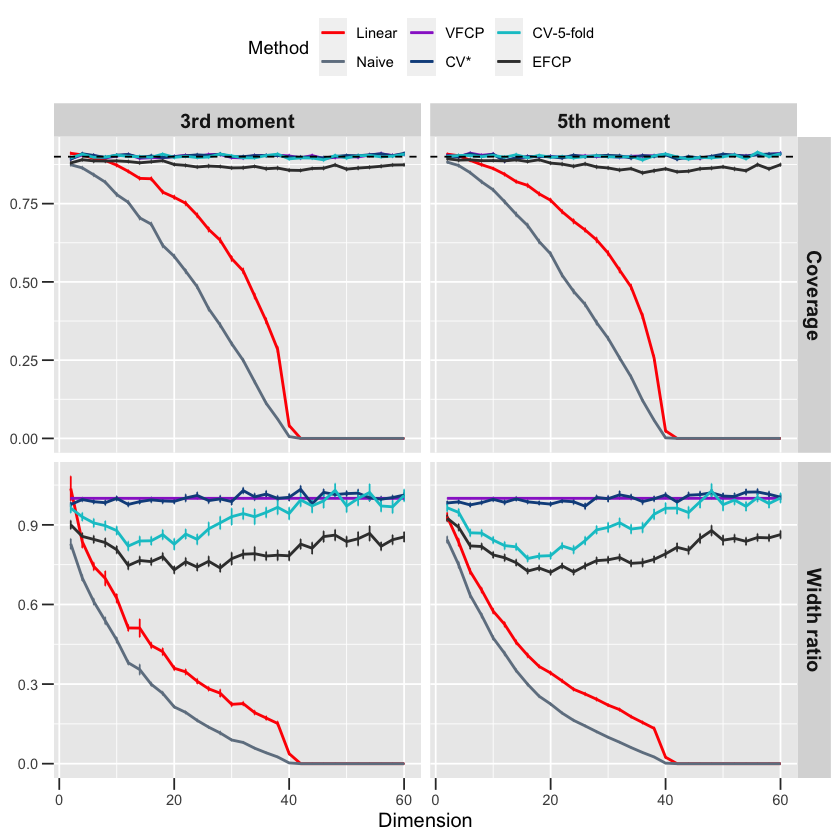

In [148]:
data_linear_fm=rbind(cov,len)
dummy_coverage <- data.frame(Var=c("Coverage"),Z= 0.9)

ggplot_linear_fm=ggplot(data=data_linear_fm, aes(x=V1, y=V2, group=Method,color=Method)) +
  geom_errorbar(aes(ymin=V2-sd, ymax=V2+sd), width=.1)+
  geom_line(size = 0.8, aes(color=Method))+  #,linetype=Method)) +
  #geom_point(size=5, colour=bgnd)+
  #geom_point(aes(shape=Method,color=Method)) +
  theme(#axis.text.y = element_blank(), 
    #axis.ticks.y = element_blank(), 
    axis.title.y = element_blank(),
    #plot.title = element_text(size = 8,hjust=0.5),
    #axis.text = element_text(size = 10),
    #axis.title =element_text(size = 10),
    legend.position="top") +
  facet_grid(Var~Moment,scales = "free")+
  #scale_shape_manual(values=shape_manual) + 
  scale_color_manual(values=colors_manual) +
  #ylim(0,1.2) + #xlab("dim") + ylab("Avg-Len")  
  xlab("Dimension")+guides(shape=FALSE)+
  theme(strip.text.x = element_text(size = 12, face = "bold"), strip.text.y = element_text(size=12, face="bold"), axis.ticks.length=unit(.25, "cm"),axis.title=element_text(size=12))+ geom_hline(data=dummy_coverage, aes(yintercept=Z), linetype="dashed")
ggsave(("ggplot_linear_fm.pdf"),ggplot_linear_fm, width = 10, height = 10, units = "in")


ggplot_linear_fm